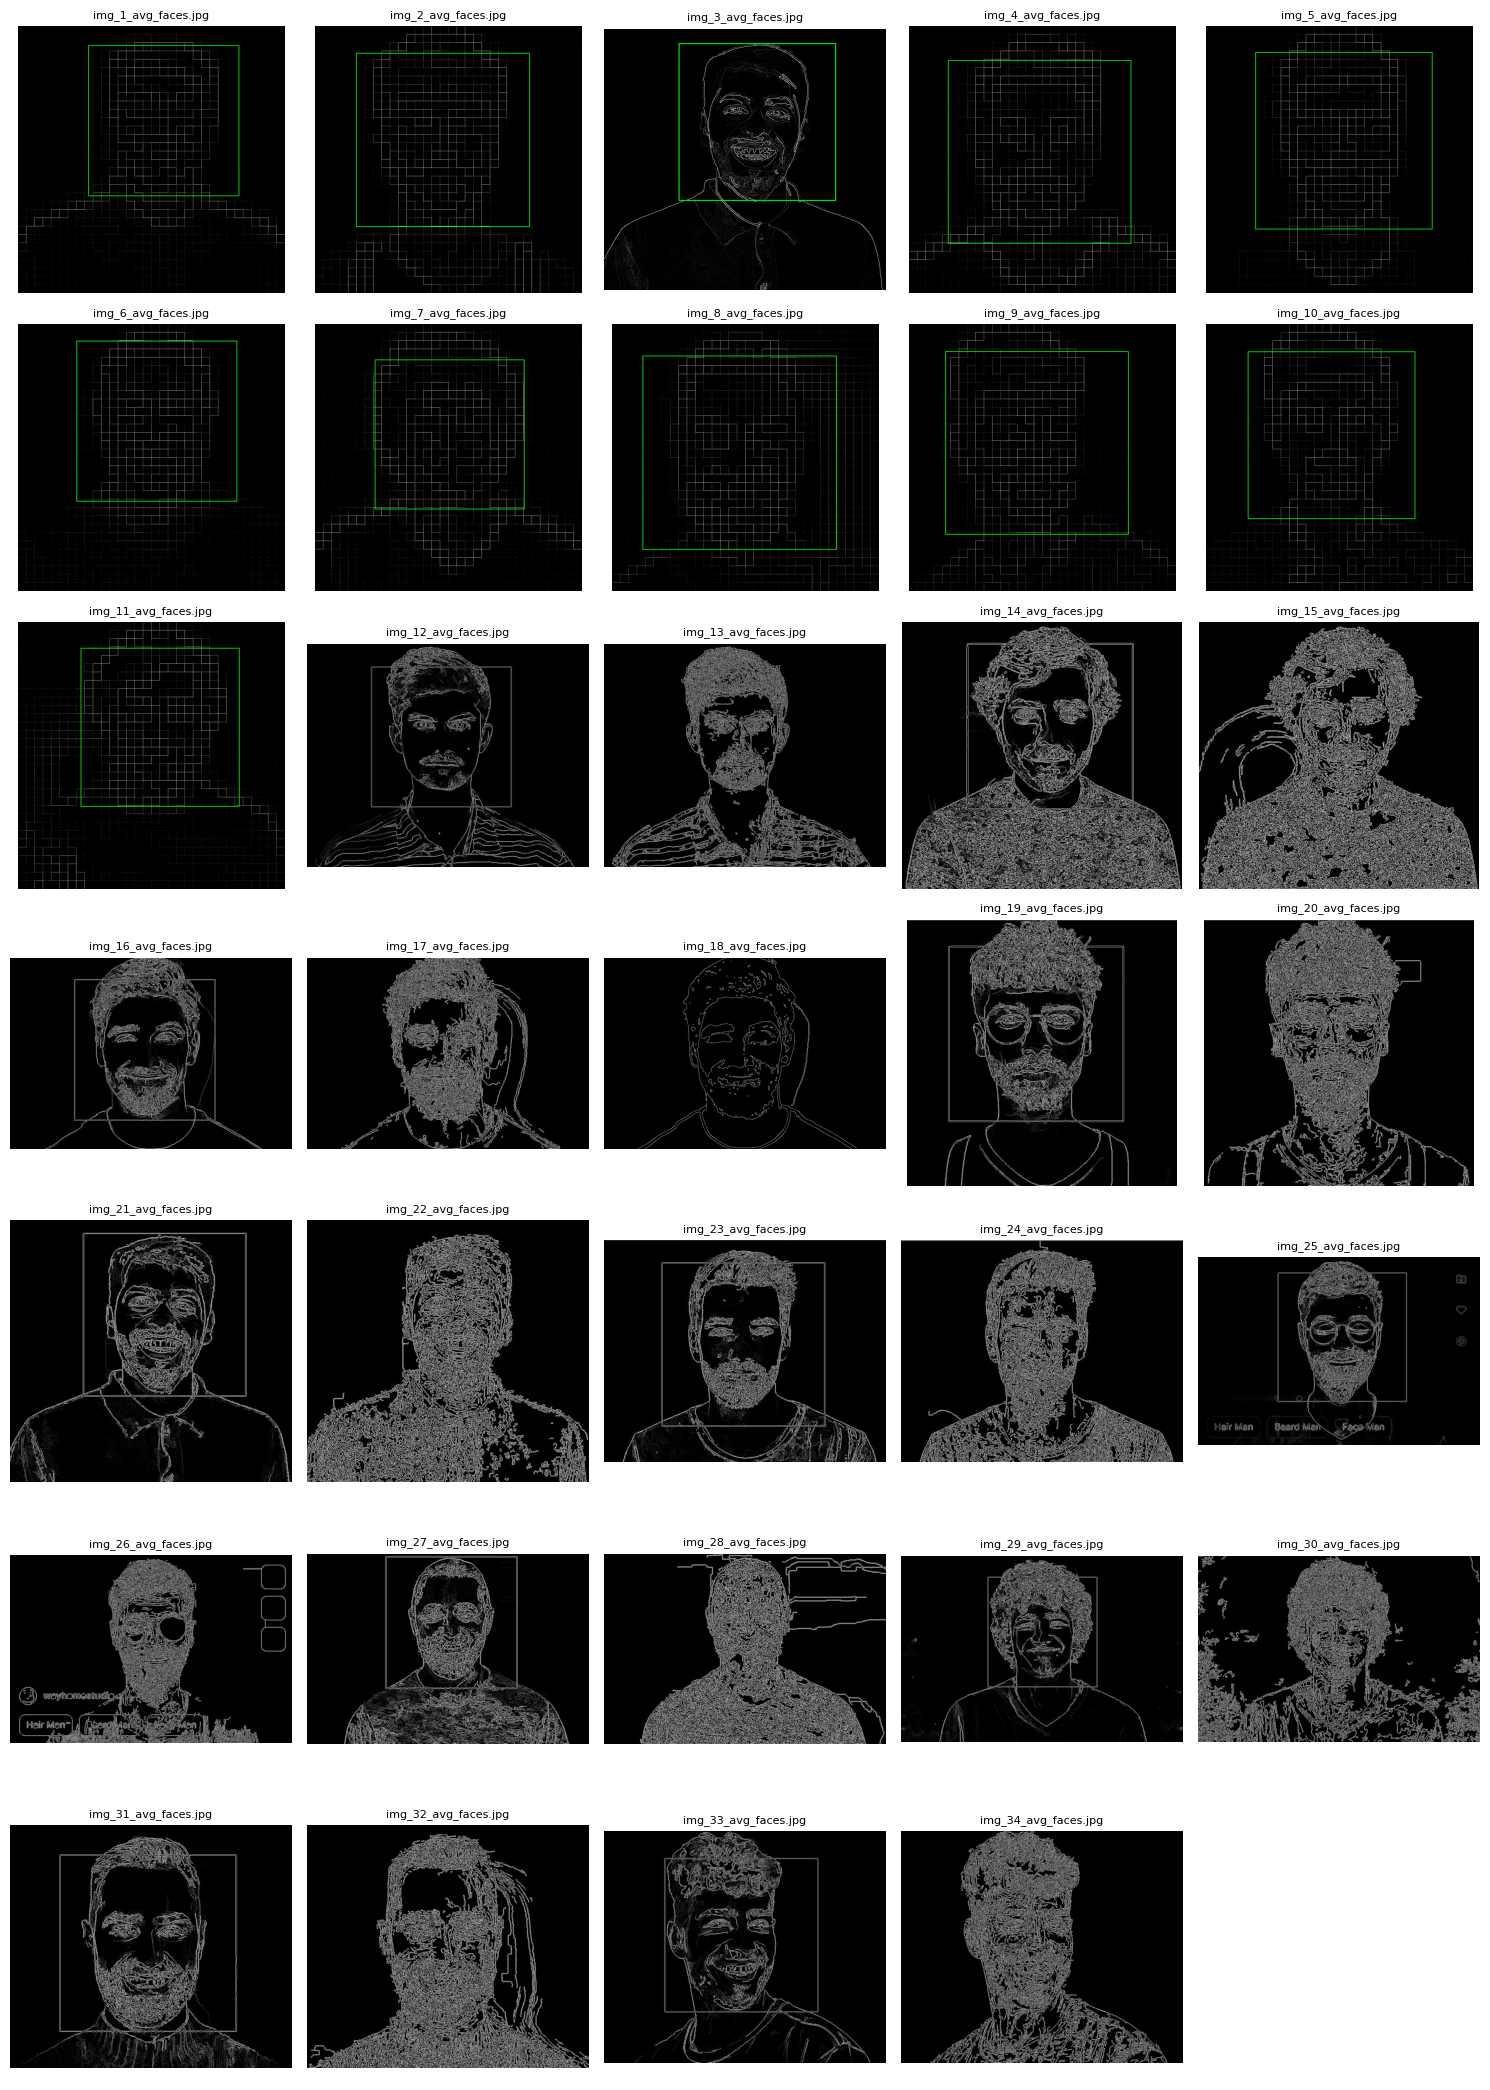

[[(270, 74, 577, 577)], [(158, 104, 665, 665)], [(209, 43, 437, 437)], [(150, 132, 701, 701)], [(190, 101, 677, 677)], [(225, 65, 614, 614)], [(230, 137, 572, 572)], [(118, 122, 742, 742)], [(140, 105, 701, 701)], [(161, 106, 640, 640)], [(241, 100, 607, 607)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [29]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

bounding_boxes = []

def canny_edge_detection(input_folder, output_folder, threshold_pairs, cascade_path, padding=0):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load the Haar Cascade Classifier for face detection
    face_cascade = cv2.CascadeClassifier(cascade_path)
    
    # Get list of all files in the input folder
    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    processed_images = []

    # Process each file with each threshold pair
    for file_index, file in enumerate(files):
        img_path = os.path.join(input_folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        edge_images = []
        for i, (lower, upper) in enumerate(threshold_pairs):
            edges = cv2.Canny(img, lower, upper)
            edge_images.append(edges)
        
        # Average all edge detection results
        avg_edges = np.mean(edge_images, axis=0).astype(np.uint8)
        
        # Create a color image from the edges for better visualization
        avg_edges_color = cv2.cvtColor(avg_edges, cv2.COLOR_GRAY2BGR)

        # Draw bounding rectangles around detected faces on the edge-detected image
        padded_faces = []
        for (x, y, w, h) in faces:
            x_pad = max(x - padding, 0)
            y_pad = max(y - padding, 0)
            w_pad = min(w + 2 * padding, img.shape[1] - x_pad)
            h_pad = min(h + 2 * padding, img.shape[0] - y_pad)
            padded_faces.append((x_pad, y_pad, w_pad, h_pad))
            cv2.rectangle(avg_edges_color, (x_pad, y_pad), (x_pad + w_pad, y_pad + h_pad), (0, 255, 0), 2)
        
        bounding_boxes.append(padded_faces)

        # Save the average edge-detected image with bounding rectangles
        avg_output_filename = f"img_{file_index+1}_avg_faces.jpg"
        avg_output_path = os.path.join(output_folder, avg_output_filename)
        cv2.imwrite(avg_output_path, avg_edges_color)
        processed_images.append((avg_edges_color, avg_output_filename))

    # Plot the processed images in a grid with 5 columns
    num_images = len(processed_images)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, (img, title) in enumerate(processed_images):
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
        axes[i].set_title(title, fontsize=8)
        axes[i].axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
input_folder = 'outputs'
output_folder = 'as'
cascade_path = 'haarcascades/haarcascade_frontalface_default.xml'  # Path to Haar Cascade XML file

def generate_threshold_pairs(start, end, step):
    threshold_pairs = [(lower, upper) 
                       for lower in range(start, end, step) 
                       for upper in range(lower + step, end + step, step)]
    return threshold_pairs

threshold_pairs = generate_threshold_pairs(0, 250, 10)
padding = 60  # Set padding value here
canny_edge_detection(input_folder, output_folder, threshold_pairs, cascade_path, padding)
print(bounding_boxes)


In [19]:
import cv2
import numpy as np
from scipy.interpolate import splprep, splev

# List to store the points
points = []

# Mouse callback function to capture points
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print(f"Point {len(points)}: ({x}, {y})")
        if len(points) == 5:
            cv2.destroyWindow("Image")

def draw_smooth_curve(image, points):
    # Convert points to numpy array
    points = np.array(points, dtype=np.float32)
    
    # Interpolate points using B-spline
    tck, u = splprep([points[:,0], points[:,1]], s=0)
    unew = np.linspace(0, 1.0, 100)
    out = splev(unew, tck)
    
    # Convert interpolated points to integer values
    curve_points = np.column_stack((out[0], out[1])).astype(np.int32)
    
    # Draw the smooth curve
    for i in range(len(curve_points) - 1):
        cv2.line(image, tuple(curve_points[i]), tuple(curve_points[i+1]), (0, 255, 0), 2)

def main(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not open or find the image.")
        return

    # Create a window and set the mouse callback function
    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", mouse_callback)

    # Display the image and wait for points to be selected
    print("Click on 5 points in the image")
    while len(points) < 5:
        cv2.imshow("Image", image)
        cv2.waitKey(1)

    # Draw the smooth curve
    draw_smooth_curve(image, points)

    # Display the final image
    cv2.imshow("Output Image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output image
    output_path = "output_image.jpg"
    cv2.imwrite(output_path, image)
    print(f"Output image saved as {output_path}")

if __name__ == "__main__":
    image_path = input("Enter the path to the image: ")
    main(image_path)


Click on 5 points in the image
Point 1: (361, 337)
Point 2: (373, 334)
Point 3: (386, 334)
Point 4: (401, 335)
Point 5: (421, 337)
Output image saved as output_image.jpg


In [22]:
import cv2
import numpy as np

def isolate_green_pixels(image_path, output_path):
    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for green color in HSV
    lower_green = np.array([50, 100, 100])
    upper_green = np.array([70, 255, 255])

    # Create a mask that isolates the green pixels
    mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Create an output image that is black
    output_image = np.zeros_like(image)

    # Apply the mask to the output image, keeping only the green pixels
    output_image[mask != 0] = image[mask != 0]

    # Save the result
    cv2.imwrite(output_path, output_image)

# Example usage
input_image_path = 'output_image.jpg'
output_image_path = 'output_image1.jpg'
isolate_green_pixels(input_image_path, output_image_path)


In [41]:
from PIL import Image
import os
import numpy as np

def apply_threshold(image, threshold=128):
    """Apply binary thresholding to a grayscale image."""
    # Convert image to numpy array
    img_array = np.array(image)
    
    # Apply the threshold
    binary_array = np.where(img_array >= threshold, 255, 0).astype(np.uint8)
    
    # Convert back to PIL image
    return Image.fromarray(binary_array)

def process_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(input_folder, filename)
            try:
                with Image.open(img_path) as img:
                    # Convert image to grayscale
                    img_gray = img.convert('L')  # 'L' mode is for grayscale
                    
                    # Apply binary thresholding
                    img_thresholded = apply_threshold(img_gray, threshold=128)
                    
                    # Crop the central square
                    width, height = img_thresholded.size
                    new_side = min(width, height)
                    left = (width - new_side) / 2
                    top = (height - new_side) / 2
                    right = (width + new_side) / 2
                    bottom = (height + new_side) / 2
                    img_cropped = img_thresholded.crop((left, top, right, bottom))
                    
                    # Downscale to 128x128
                    img_downscaled = img_cropped.resize((128, 128), Image.LANCZOS)
                    
                    # Create a new 1024x1024 image
                    img_upscaled = Image.new('L', (1024, 1024))  # 'L' mode for grayscale
                    
                    # Upscale by filling blocks with the grayscale pixel value
                    for y in range(128):
                        for x in range(128):
                            color = img_downscaled.getpixel((x, y))
                            img_upscaled.paste(Image.new('L', (8, 8), color=color), (x * 8, y * 8))
                    
                    # Save the processed image
                    output_path = os.path.join(output_folder, filename)
                    img_upscaled.save(output_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Example usage
input_folder = 'inputs'
output_folder = 'outputs'
process_images(input_folder, output_folder)


IndexError: index 205 is out of bounds for axis 0 with size 205

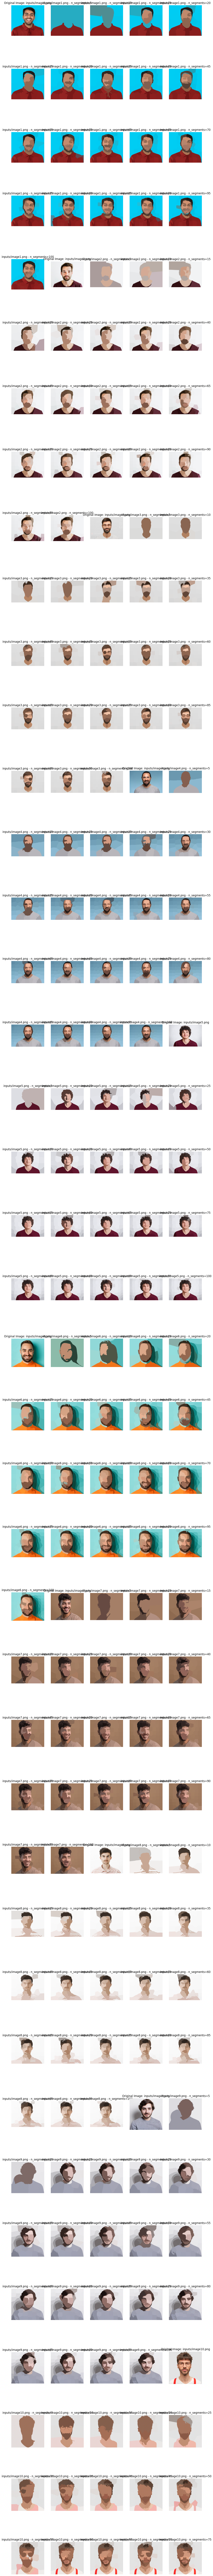

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.segmentation import slic
from skimage.measure import label
from skimage.color import label2rgb

def superpixel_and_structure_extraction(image_path, n_segments, display=False):
    # Read the image
    image = io.imread(image_path)
    
    # Convert RGBA to RGB if the image has an alpha channel
    if image.shape[-1] == 4:
        image = color.rgba2rgb(image)
    
    # Apply SLIC for super-pixel segmentation
    segments = slic(image, n_segments=n_segments, compactness=10)
    
    # Label the unique structures
    labeled_segments = label(segments)
    
    # Color each unique structure differently
    colored_segments = label2rgb(labeled_segments, image, kind='avg')
    
    if display:
        return image, colored_segments
    else:
        return None, colored_segments

# Example usage
image_paths = [f'inputs/image{i}.png' for i in range(1, 11)]
num_columns = 5
num_segments = range(5, 101, 5)

# Calculate the number of rows needed
num_rows = (len(num_segments) * len(image_paths)) // num_columns + 1

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
axes = axes.flatten()

# Counter for subplot index
subplot_idx = 0

for image_path in image_paths:
    # Display original image once per row set
    original_image, _ = superpixel_and_structure_extraction(image_path, 5, display=True)
    axes[subplot_idx].imshow(original_image)
    axes[subplot_idx].set_title(f'Original Image: {image_path}')
    axes[subplot_idx].axis('off')
    subplot_idx += 1
    
    # Iterate over n_segments and display the results
    for n_segments in num_segments:
        _, result = superpixel_and_structure_extraction(image_path, n_segments, display=True)
        axes[subplot_idx].imshow(result)
        axes[subplot_idx].set_title(f'{image_path} - n_segments={n_segments}')
        axes[subplot_idx].axis('off')
        subplot_idx += 1

# Hide any unused subplots
for ax in axes[subplot_idx:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
